# 1. Introduction

# 2. Problem Statement

Arrest Flag

# 3. Objectives

# 4. Data Understanding

### Imports & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score



In [2]:
import pandas as pd

df = pd.read_csv('Terry_Stops_20240819.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,23:52:00.0000000,-,-,-,WEST PCT 3RD W - MARY - PLATOON 1,N,N,-,-,-
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,-,7560,1986,M,White,...,12:24:59.0000000,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,16:18:00.0000000,-,-,-,WEST PCT OPS - CPT,N,N,-,-,-
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,15:53:00.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,15:51:00.0000000,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2


### Exploratory Data Analysis (EDA)

In [3]:
df.shape

(60962, 23)

In [4]:
df.describe()

,Subject ID,GO / SC Num,Terry Stop ID,Officer YOB
count,6.096200e+04,6.096200e+04,6.096200e+04,60962.000000
mean,7.246509e+09,2.018660e+13,1.213135e+10,1984.077474
std,1.265918e+10,8.575239e+10,1.749055e+10,9.472551
min,-8.000000e+00,-1.000000e+00,2.802000e+04,1900.000000
25%,-1.000000e+00,2.017000e+13,2.387742e+05,1979.000000
50%,-1.000000e+00,2.018000e+13,5.086870e+05,1986.000000
75%,7.752270e+09,2.021000e+13,1.953036e+10,1991.000000
max,5.845336e+10,2.024000e+13,5.845333e+10,2002.000000


Our data has 23 columns and 609562 rows

In [5]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

These are the columns in our data and their descriptions based on a review of our data and information from our data source: (https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8/about_data):

1. Subject Age Group - Subject Age Group (10 year increments) as reported by the officer (Text)

2. Subject ID - Key, generated daily, identifying unique subjects in the dataset using a character to character match of first name and last         name. "Null" values indicate an "anonymous" or "unidentified" subject. Subjects of a Terry Stop are not required to present identification. (Text)

3. GO / SC Num - General Offense or Street Check number, relating the Terry Stop to the parent report. This field may have a one to many relationship in the data. (Text)

4. Terry Stop ID - 	Key identifying unique Terry Stop reports. (Text)

5. Stop Resolution - Resolution of the stop as reported by the officer. (Text)

6. Weapon Type - Type of weapon, if any, identified during a search or frisk of the subject. Indicates "None" if no weapons was found. (Text)

7. Officer ID  - Key identifying unique officers in the dataset. (Text)

8. Officer YOB - Year of birth, as reported by the officer. (Text)

9. Officer Gender - Gender of the officer, as reported by the officer. (Text)

10. Officer Race - Race of the officer, as reported by the officer. (Text)

11. Subject Perceived Race - Perceived race of the subject, as reported by the officer. (Text)

12. Subject Perceived Gender - Perceived gender of the subject, as reported by the officer. (Text)

13. Reported Date - Date the report was filed in the Records Management System (RMS). Not necessarily the date the stop occurred but generally within 1 day. (Floating Timestamp)

14. Reported Time - Time the stop was reported in the Records Management System (RMS). Not the time the stop occurred but generally within 10 hours. (Text)

15. Initial Call Type - Initial classification of the call as assigned by 911. (Text)

16. Final Call Type - Final classification of the call as assigned by the primary officer closing the event. (Text)

17. Call Type - How the call was received by the communication center. (Text)

18. Officer Squad - Functional squad assignment (not budget) of the officer as reported by the Data Analytics Platform (DAP). (Text)

19. Arrest Flag - Indicator of whether a "physical arrest" was made, of the subject, during the Terry Stop. Does not necessarily reflect a report of an arrest in the Records Management System (RMS). (Text)

20. Frisk Flag - Indicator of whether a "frisk" was conducted, by the officer, of the subject, during the Terry Stop. (Text)

21. Precint - Precinct of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred. (Text)

22. Sector - Sector of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred. (Text)

23. Beat - Beat of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred. (Text)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60962 entries, 0 to 60961
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         60962 non-null  object
 1   Subject ID                60962 non-null  int64 
 2   GO / SC Num               60962 non-null  int64 
 3   Terry Stop ID             60962 non-null  int64 
 4   Stop Resolution           60962 non-null  object
 5   Weapon Type               60962 non-null  object
 6   Officer ID                60962 non-null  object
 7   Officer YOB               60962 non-null  int64 
 8   Officer Gender            60962 non-null  object
 9   Officer Race              60962 non-null  object
 10  Subject Perceived Race    60962 non-null  object
 11  Subject Perceived Gender  60962 non-null  object
 12  Reported Date             60962 non-null  object
 13  Reported Time             60962 non-null  object
 14  Initial Call Type     

In [7]:
df.isna().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Weapon Type                   0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               561
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
dtype: int64

We have missing data in the Officer Squad column. We will impute this column with a placeholder 'Unknown' Value

In [8]:
df_imputed = df.fillna('Unknown')
df_imputed.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,23:52:00.0000000,-,-,-,WEST PCT 3RD W - MARY - PLATOON 1,N,N,-,-,-
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,-,7560,1986,M,White,...,12:24:59.0000000,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,16:18:00.0000000,-,-,-,WEST PCT OPS - CPT,N,N,-,-,-
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,15:53:00.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,15:51:00.0000000,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2


We also seem to have rows filled with '-'. We will treat these as missing values. 
First we need to convert these to NaN	

In [9]:
for column in df_imputed.columns:
    df_imputed[column] = df_imputed[column].replace('-', np.nan)

In [10]:
df_imputed.isna().sum()

Subject Age Group            2200
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 24528
Officer ID                     24
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race       1816
Subject Perceived Gender      243
Reported Date                   0
Reported Time                   0
Initial Call Type           13473
Final Call Type             13473
Call Type                   13473
Officer Squad                   0
Arrest Flag                     0
Frisk Flag                    478
Precinct                    10617
Sector                      10768
Beat                        10762
dtype: int64

After deeper analysis of our data, we have several more columns with missing data.

We will handle these columns separately to preserve the quality of our data.

1. Subject Age Group  - we can impute this with mode to preserve the shape of our data.

2. Weapon Type - Given that a large portion is missing, it’s possible that in many cases, no weapon was found. Imputing missing values with "None" might be logical.

3. Officer ID - Since only 24 out of 60,962 entries are affected, we will drop these rows.

4. Subject Perceived Race - Replacing missing values with "Unknown" maintains the data structure without introducing bias.

5. Subject Perceived Gender - Replacing missing values with "Unknown" maintains the data structure without introducing bias.

6. Initial Call Type, Final Call Type, Call Type - Missing call types might suggest a lack of information or a specific condition (e.g., not applicable since no call was made and the incident just transpired). Imputing with "Unknown" preserves this possibility.

7. Frisk Flag - Since the missing values are minimal, using the most frequent value could be effective.

8. Precint, Sector, Beat - Geographic information might be missing due to unreported locations. Filling with "Unknown" allows us to retain these rows.


In [11]:
columns_to_fill_with_mode = ['Subject Age Group', 'Frisk Flag']
columns_to_fill_with_unkown = ['Subject Perceived Race', 'Subject Perceived Gender', 'Initial Call Type'
, 'Final Call Type', 'Call Type', 'Precinct', 'Sector', 'Beat']
columns_to_fill_with_none = ['Weapon Type']
columns_to_drop = ['Officer ID']

for column in columns_to_fill_with_mode:
    df_imputed[column] = df_imputed[column].fillna(df_imputed[column].mode()[0])

for column in columns_to_fill_with_unkown:
    df_imputed[column] = df_imputed[column].fillna('Unknown')

for column in columns_to_fill_with_none:
    df_imputed[column] = df_imputed[column].fillna('None')

for column in columns_to_drop:
    df_imputed.dropna(inplace=True)

In [12]:
df_imputed.isna().sum()

Subject Age Group           0
Subject ID                  0
GO / SC Num                 0
Terry Stop ID               0
Stop Resolution             0
Weapon Type                 0
Officer ID                  0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Reported Time               0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Officer Squad               0
Arrest Flag                 0
Frisk Flag                  0
Precinct                    0
Sector                      0
Beat                        0
dtype: int64

Our dataset no longer contains missing values.

#### Columns to drop:

Next, we will drop some columns that do not provide useful information for our analysis. From a review of the column descriptions, we can ignore the following columns:

1. Subject ID: This is a unique identifier for each subject, not useful for modeling.

2. GO / SC Num: Unique identifier for reports, irrelevant for prediction.

3. Terry Stop ID: Another unique identifier.

4. Officer ID: Identifies each officer; may introduce bias and is not necessary.

5. Reported Date & Reported Time: Since they represent when the report was filed, not when the stop occurred, they may not be useful.


We can use Officer YOB - Officer Year of Birth to extract and Age and put it this age into bins similar to our Subject Age Group by subtracting their year of birth from the year of the stop. 

In [13]:
bins = df_imputed['Subject Age Group'].unique()
bins

array(['1 - 17', '36 - 45', '18 - 25', '46 - 55', '26 - 35',
       '56 and Above'], dtype=object)

In [14]:

# Calculate Officer Age and add this to a new column
report_year = df_imputed['Reported Date'].str[:4].astype(int)
df_imputed['Officer Age'] = report_year - df_imputed['Officer YOB']
df_imputed.head()


,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,Unknown,Unknown,Unknown,WEST PCT 3RD W - MARY - PLATOON 1,N,N,Unknown,Unknown,Unknown,45
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,None,7560,1986,M,White,...,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1,36
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,Unknown,Unknown,Unknown,WEST PCT OPS - CPT,N,N,Unknown,Unknown,Unknown,55
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3,42
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2,53


In [15]:
df_imputed['Officer Age'].describe()

count    60938.000000
mean        34.590666
std          8.793464
min         21.000000
25%         28.000000
50%         33.000000
75%         39.000000
max        121.000000
Name: Officer Age, dtype: float64

It's unlikely we have on duty officers above the age of 65 so we can drop rows with officers above this age

In [16]:
df_imputed = df_imputed[df_imputed['Officer Age'] <= 65]

df_imputed.head()


,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,Unknown,Unknown,Unknown,WEST PCT 3RD W - MARY - PLATOON 1,N,N,Unknown,Unknown,Unknown,45
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,None,7560,1986,M,White,...,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1,36
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,Unknown,Unknown,Unknown,WEST PCT OPS - CPT,N,N,Unknown,Unknown,Unknown,55
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3,42
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2,53


In [17]:
df_imputed['Officer Age'].describe()

count    60835.000000
mean        34.469467
std          8.238621
min         21.000000
25%         28.000000
50%         33.000000
75%         39.000000
max         65.000000
Name: Officer Age, dtype: float64

In [18]:
# Initialize bin_edges list and handle bins
bin_edges = []
for bin in bins:
    if bin == '56 and Above':
        bin_edges.append(56)  # Set the lower bound for the last bin to 56
    else:
        lower_bound = int(bin.split(' - ')[0])
        bin_edges.append(lower_bound)
        

# Add the upper bound from the last bin 
max_age = df_imputed['Officer Age'].max()  
bin_edges.append(max_age)

# Remove duplicates and sort bin_edges
bin_edges = sorted(set(bin_edges))  

bin_edges

[1, 18, 26, 36, 46, 56, 65]

In [19]:
labels = df_imputed['Subject Age Group'].unique().tolist()
labels

['1 - 17', '36 - 45', '18 - 25', '46 - 55', '26 - 35', '56 and Above']

In [20]:
print('length of bin_dedges: ', len(bin_edges)-1)
print('length of labels: ', len(labels))

length of bin_dedges:  6
length of labels:  6


In [21]:
labels = df_imputed['Subject Age Group'].unique().tolist()
if len(bin_edges) - 1 != len(labels):
    raise ValueError("The number of labels does not match the number of bins")

In [22]:
# Apply pd.cut() to create the bins for Officer Age
df_imputed['Officer Age Group'] = pd.cut(df_imputed['Officer Age'], bins=bin_edges, labels=labels, right=True)

print('Officer Age Group:', bins)
print('Subject Age Group:', labels)
df_imputed.head()



Officer Age Group: ['1 - 17' '36 - 45' '18 - 25' '46 - 55' '26 - 35' '56 and Above']
Subject Age Group: ['1 - 17', '36 - 45', '18 - 25', '46 - 55', '26 - 35', '56 and Above']


,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age,Officer Age Group
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,Unknown,Unknown,WEST PCT 3RD W - MARY - PLATOON 1,N,N,Unknown,Unknown,Unknown,45,46 - 55
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,None,7560,1986,M,White,...,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1,36,18 - 25
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,Unknown,Unknown,WEST PCT OPS - CPT,N,N,Unknown,Unknown,Unknown,55,26 - 35
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3,42,46 - 55
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2,53,26 - 35


In [23]:
#change the datatype so Officer Age Group and Subject Age Group to ordinal categorical values.
df_imputed['Officer Age Group'] = pd.Categorical(df_imputed['Officer Age Group'],
                                         categories=bins,
                                         ordered=True)
df_imputed['Subject Age Group'] = pd.Categorical(df_imputed['Subject Age Group'],
                                         categories=labels,
                                         ordered=True)

In [24]:
columns_to_drop = ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Officer ID', 'Reported Date', 'Reported Time','Officer Age','Officer YOB']

df_preprocessed = df_imputed.drop(columns=columns_to_drop, axis =1)

df_preprocessed.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age Group
0,1 - 17,Offense Report,None,M,White,Unknown,Female,Unknown,Unknown,Unknown,WEST PCT 3RD W - MARY - PLATOON 1,N,N,Unknown,Unknown,Unknown,46 - 55
1,36 - 45,Arrest,None,M,White,Unknown,Male,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1,18 - 25
2,18 - 25,Field Contact,None,M,Hispanic or Latino,White,Male,Unknown,Unknown,Unknown,WEST PCT OPS - CPT,N,N,Unknown,Unknown,Unknown,26 - 35
3,46 - 55,Field Contact,None,M,White,American Indian or Alaska Native,Female,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3,46 - 55
4,26 - 35,Offense Report,None,M,Black or African American,White,Female,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2,26 - 35


We have dropped 6 columns 'Subject ID', 'Officer YOB', 'GO / SC Num', 'Terry Stop ID', 'Officer ID', 'Reported Date',and 'Reported Time' from our original dataset and added one new column - Officer Age Group

Let us look at what our dataset looks like now

In [25]:
df_preprocessed.shape

(60835, 17)

Our dataset now has 17 columns and 60,835 rows

In [26]:
df_preprocessed.columns

Index(['Subject Age Group', 'Stop Resolution', 'Weapon Type', 'Officer Gender',
       'Officer Race', 'Subject Perceived Race', 'Subject Perceived Gender',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat',
       'Officer Age Group'],
      dtype='object')

In [31]:
df_preprocessed['Subject Age Group']

0              1 - 17
1             36 - 45
2             18 - 25
3             46 - 55
4             26 - 35
             ...     
60957    56 and Above
60958         18 - 25
60959         26 - 35
60960         36 - 45
60961         36 - 45
Name: Subject Age Group, Length: 60835, dtype: category
Categories (6, object): ['1 - 17' < '36 - 45' < '18 - 25' < '46 - 55' < '26 - 35' < '56 and Above']

In [28]:
df_preprocessed.describe()

,Subject Age Group,Stop Resolution,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age Group
count,60835,60835,60835,60835,60835,60835,60835,60835,60835,60835,60835,60835,60835,60835,60835,60835,60835
unique,6,5,22,2,8,10,6,180,196,7,271,2,2,8,20,55,5
top,26 - 35,Field Contact,None,M,White,White,Male,Unknown,Unknown,911,TRAINING - FIELD TRAINING SQUAD,N,N,West,Unknown,Unknown,18 - 25
freq,22516,29433,56972,53934,43605,29820,48036,13400,13400,28775,6499,54277,46277,16793,10756,10750,32773


#### Types of Variables:

Next we will look at the types of variables in our dataset. 

In [29]:
# Identify categorical and numerical variables
categorical = [var for var in df_preprocessed.columns if df_preprocessed[var].dtype in ['O', 'category']]
numerical = [var for var in df_preprocessed.columns if df_preprocessed[var].dtype not in ['O', 'category']]

print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)

print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :', categorical)


There are 0 numerical variables

The numerical variables are : []
There are 17 categorical variables

The categorical variables are : ['Subject Age Group', 'Stop Resolution', 'Weapon Type', 'Officer Gender', 'Officer Race', 'Subject Perceived Race', 'Subject Perceived Gender', 'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad', 'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat', 'Officer Age Group']


All our features are categorical variables. 

### Visualizing the distribution of our columns

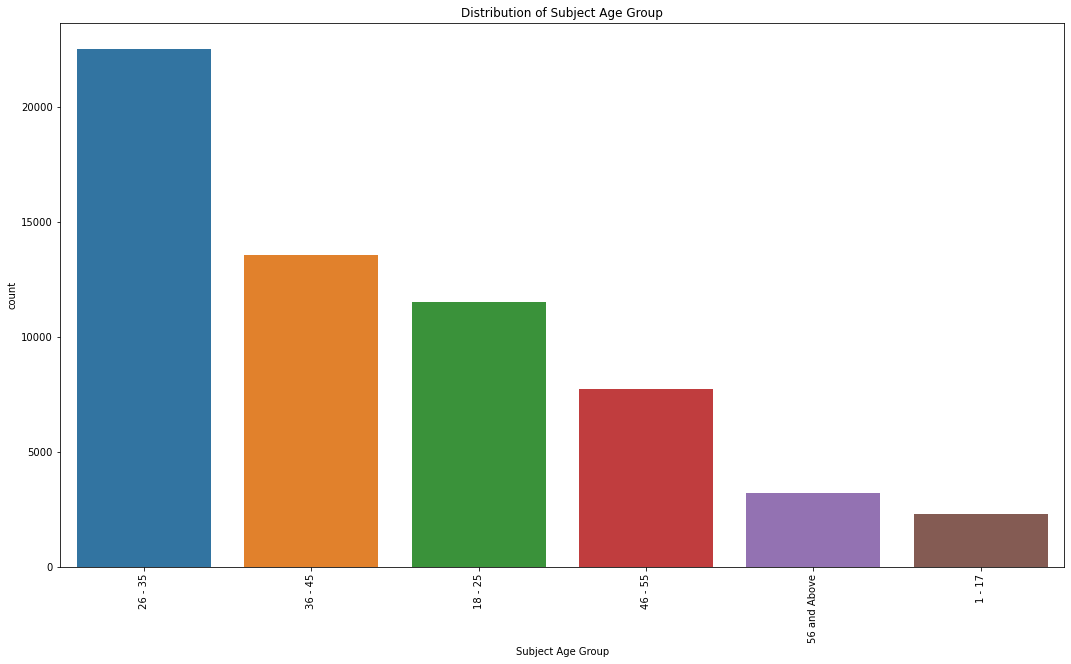

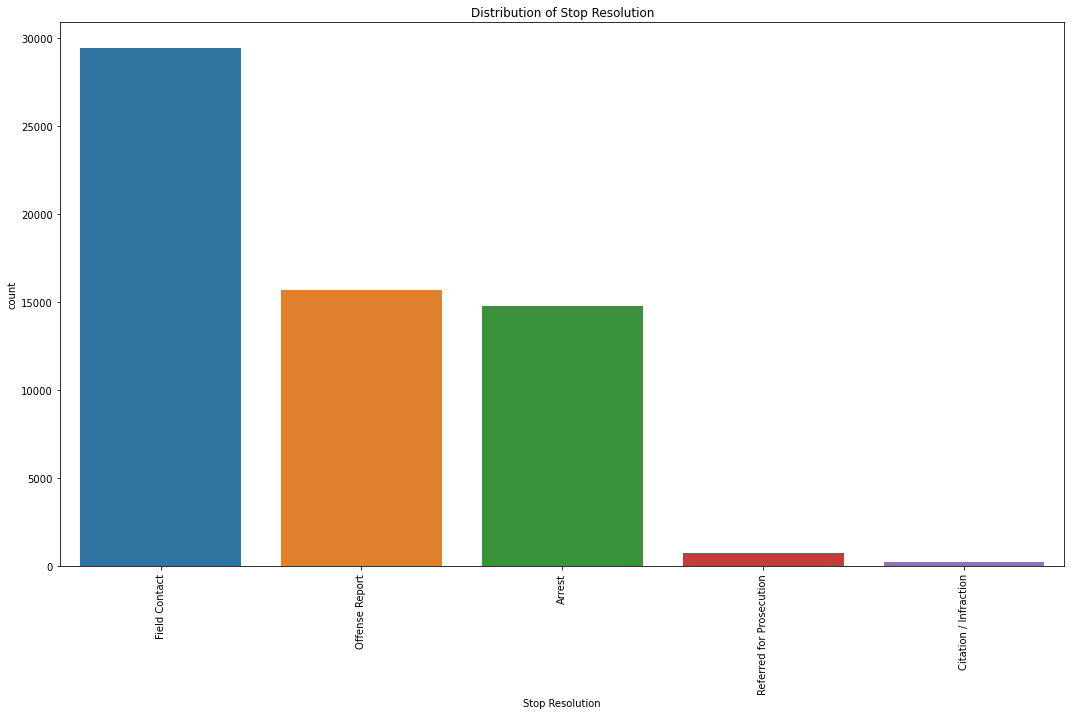

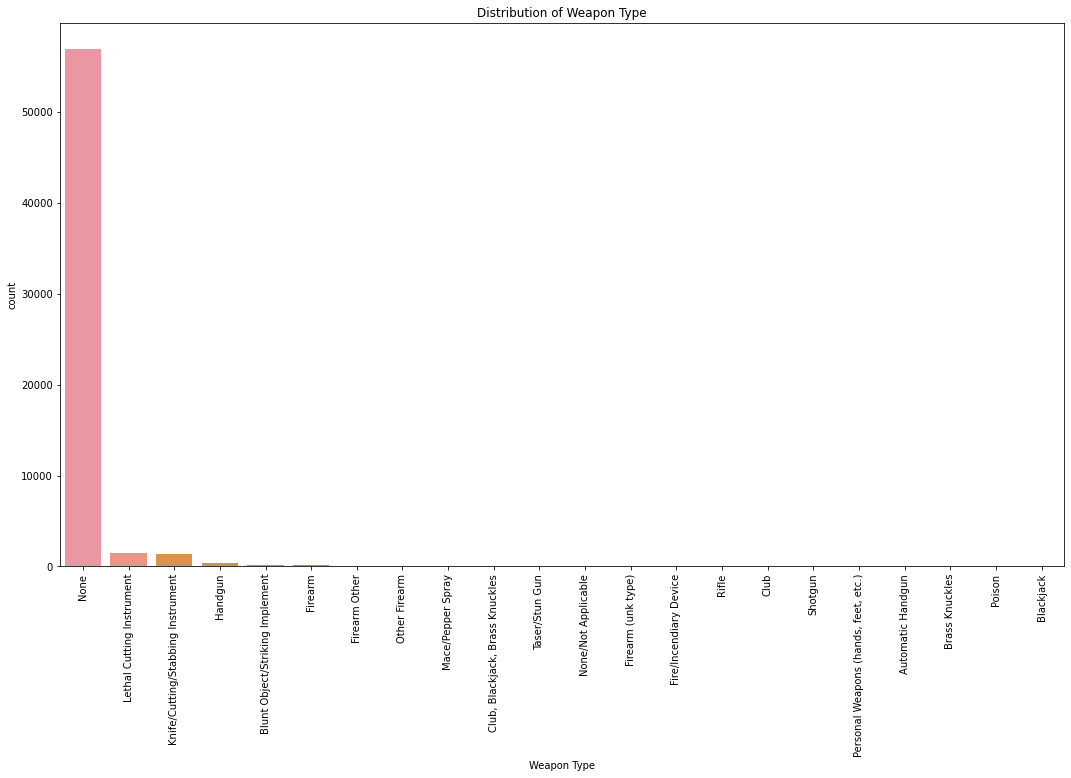

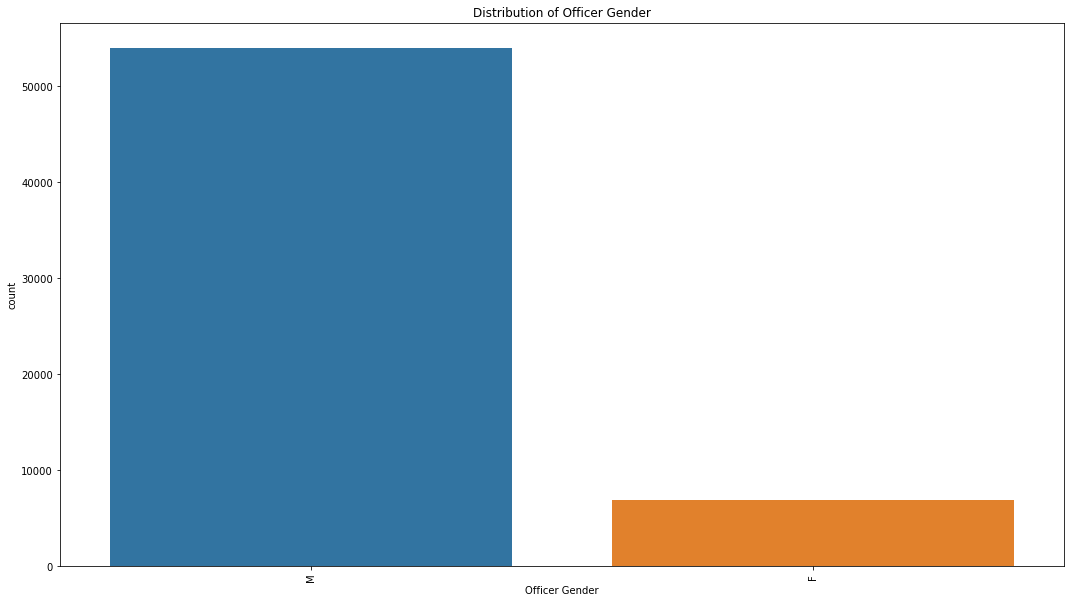

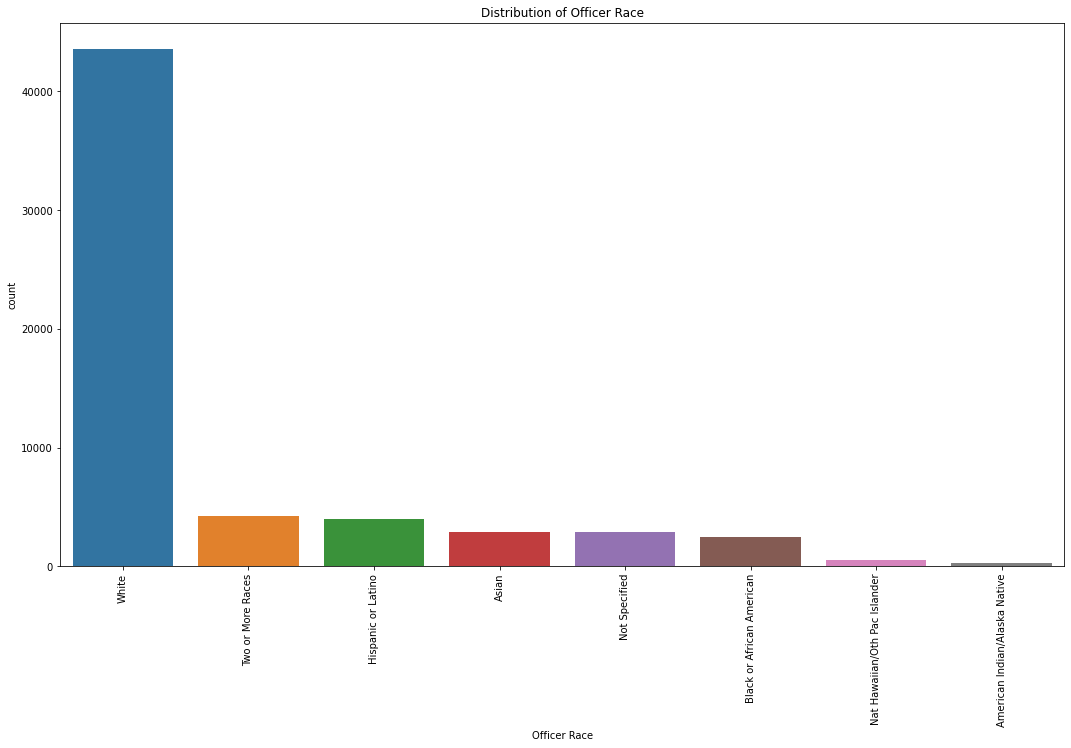

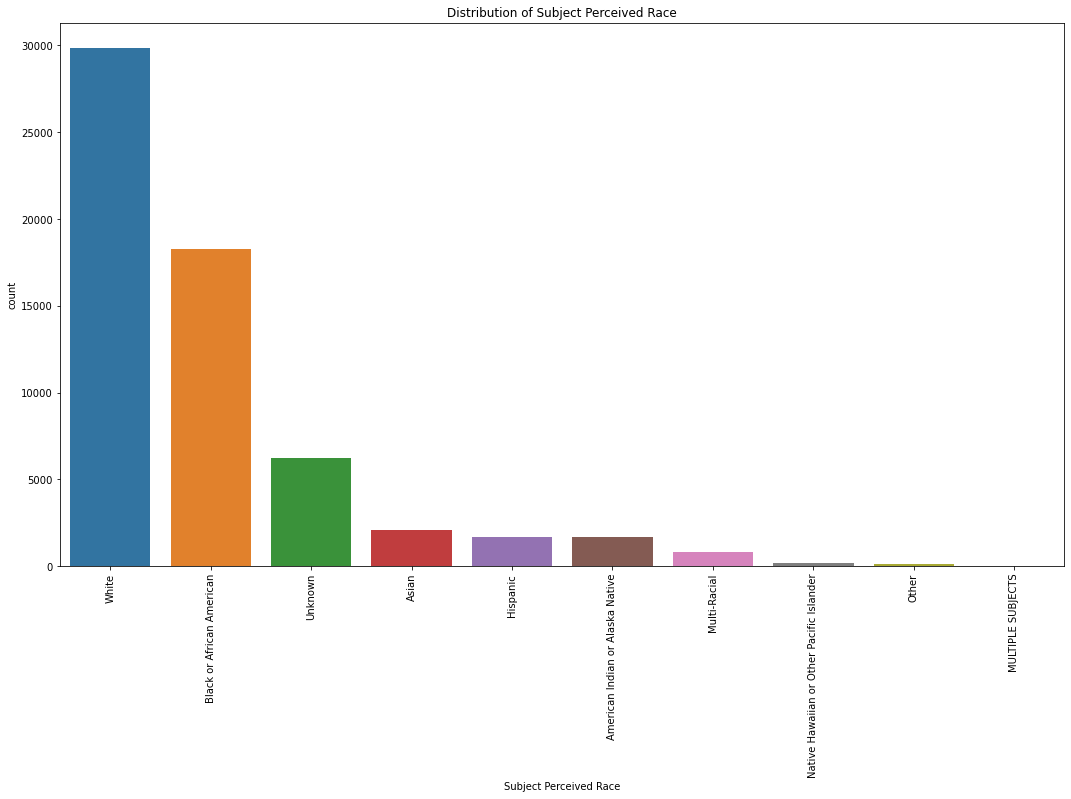

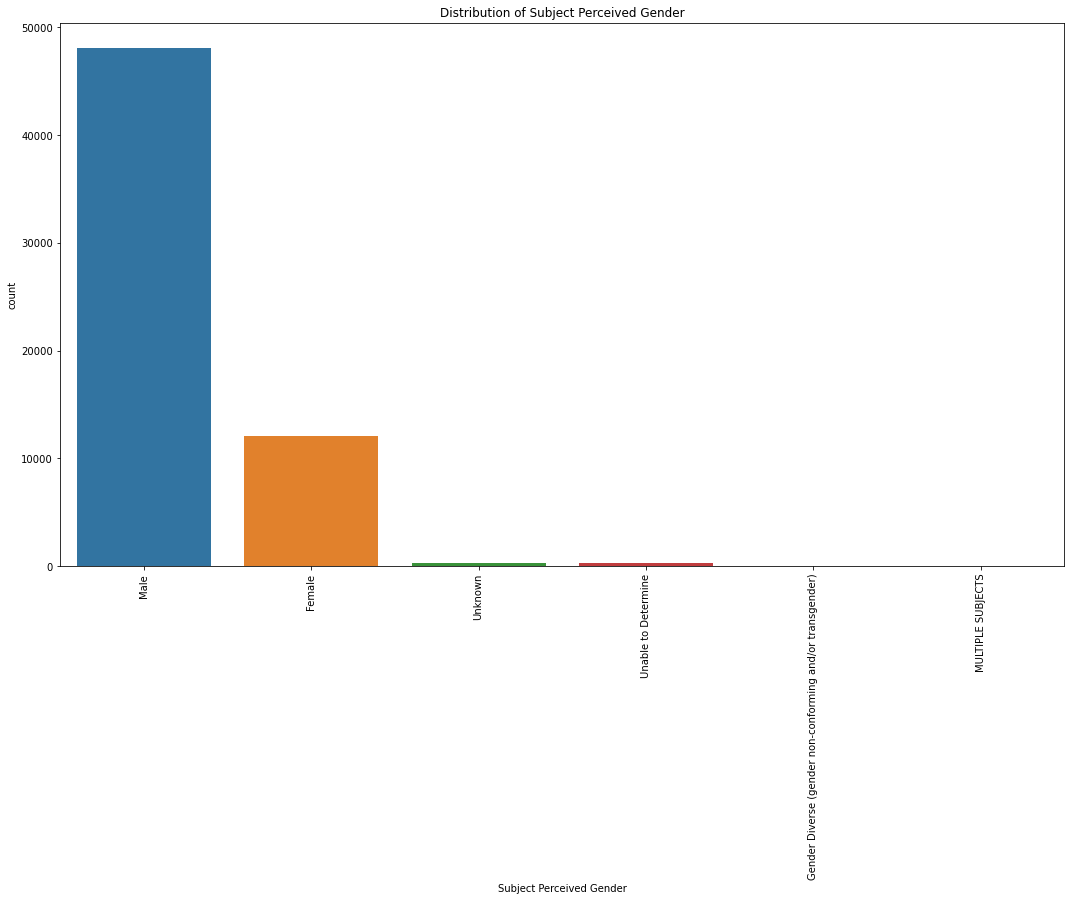

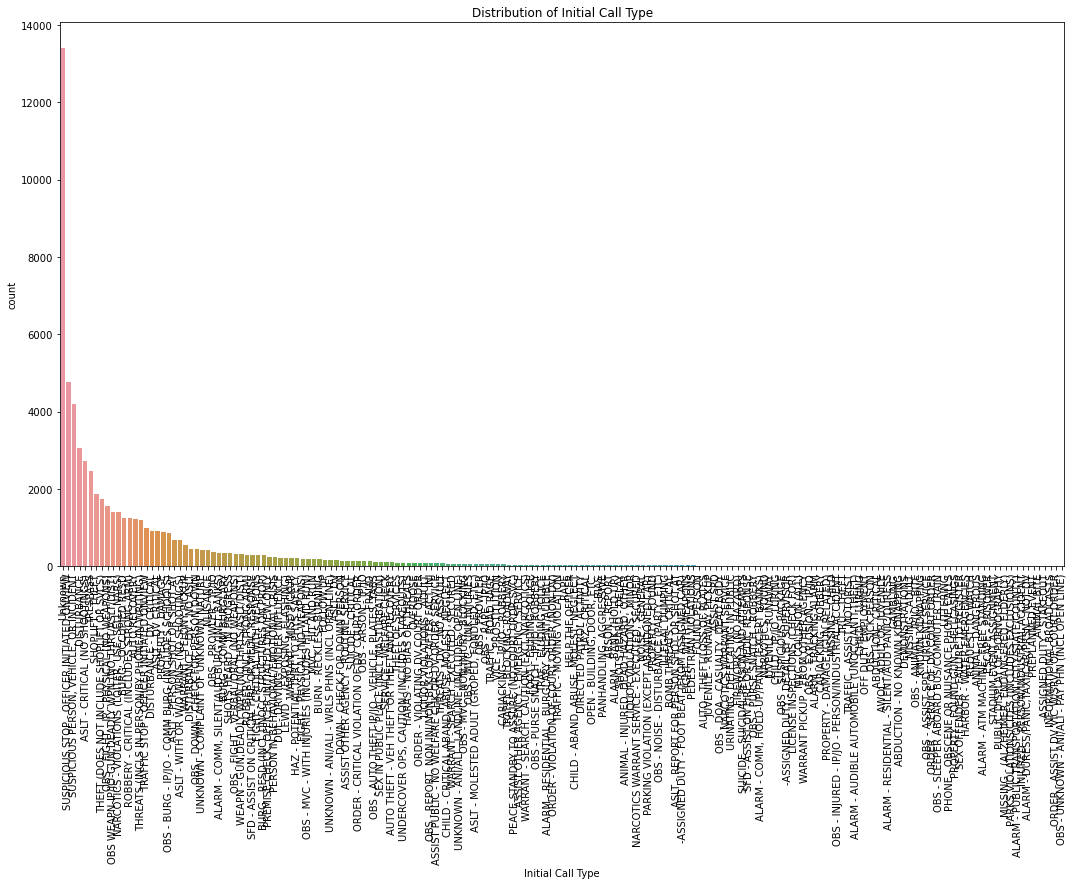

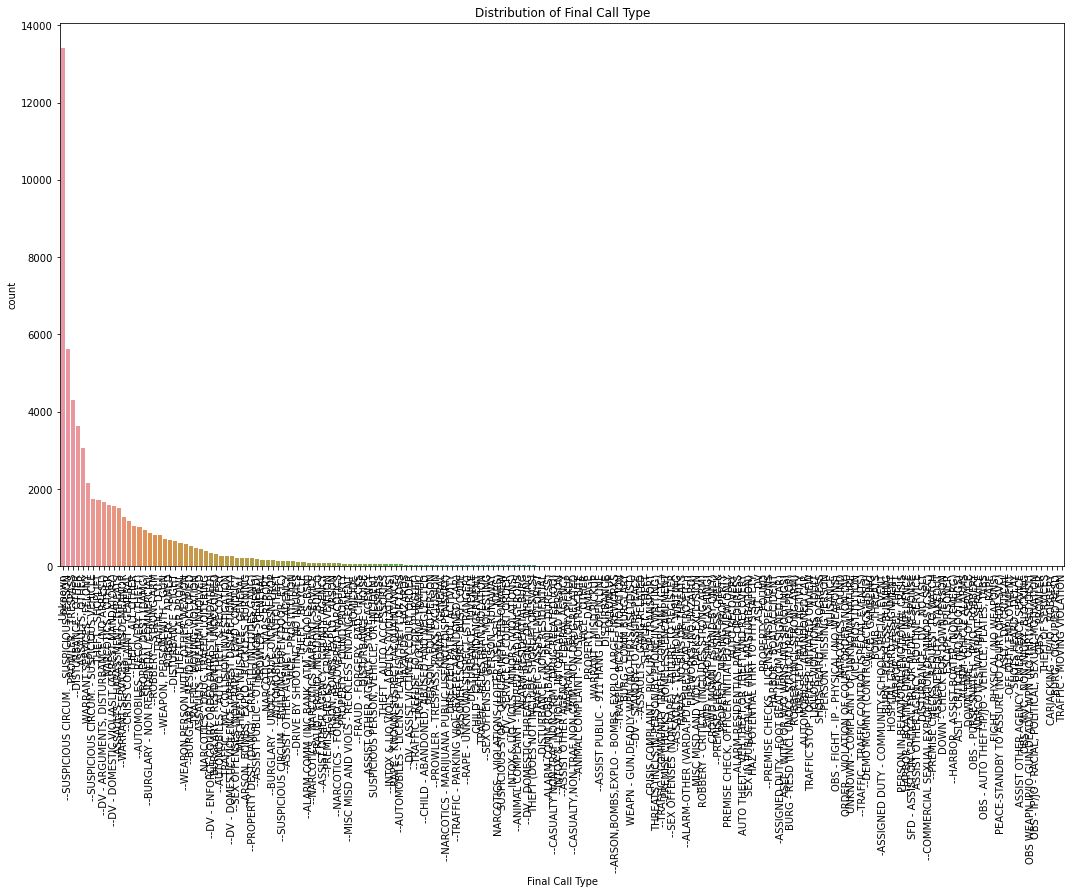

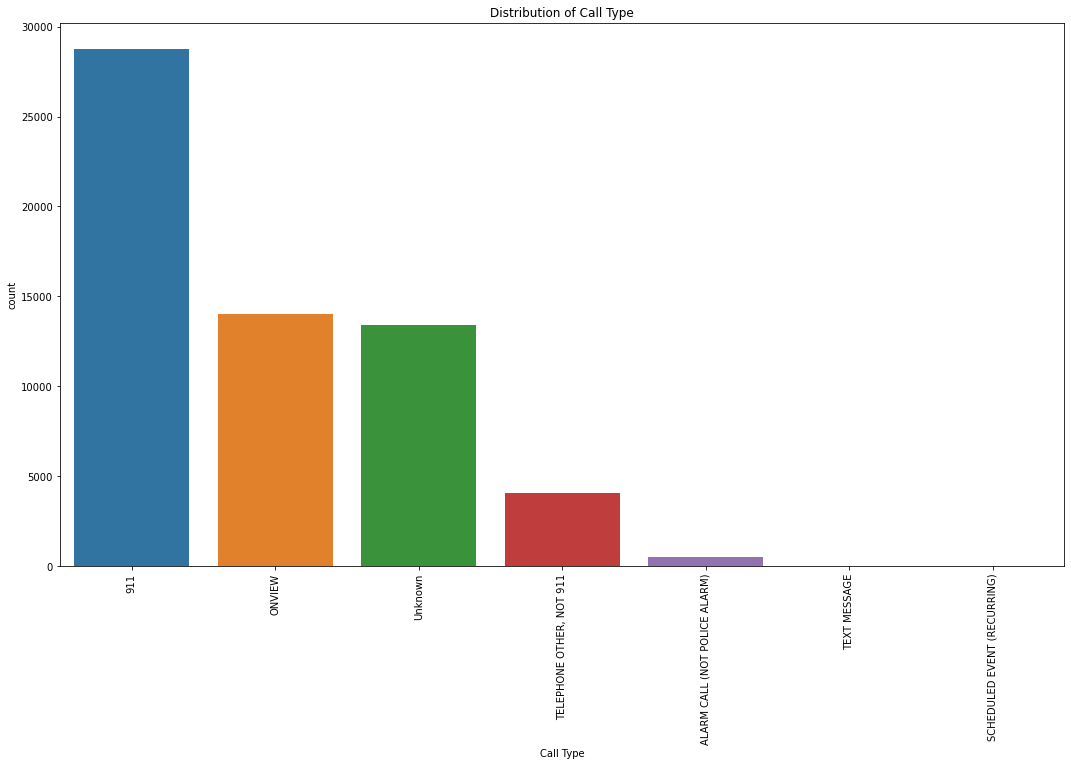

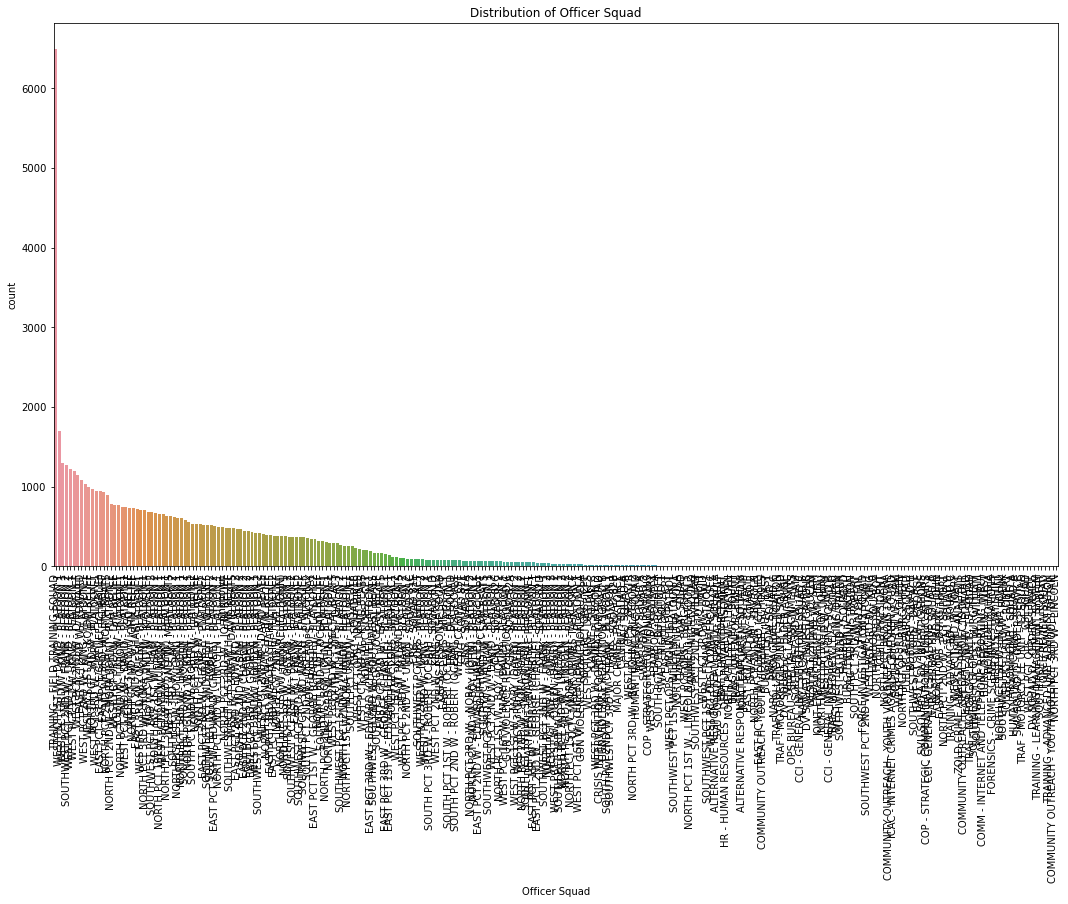

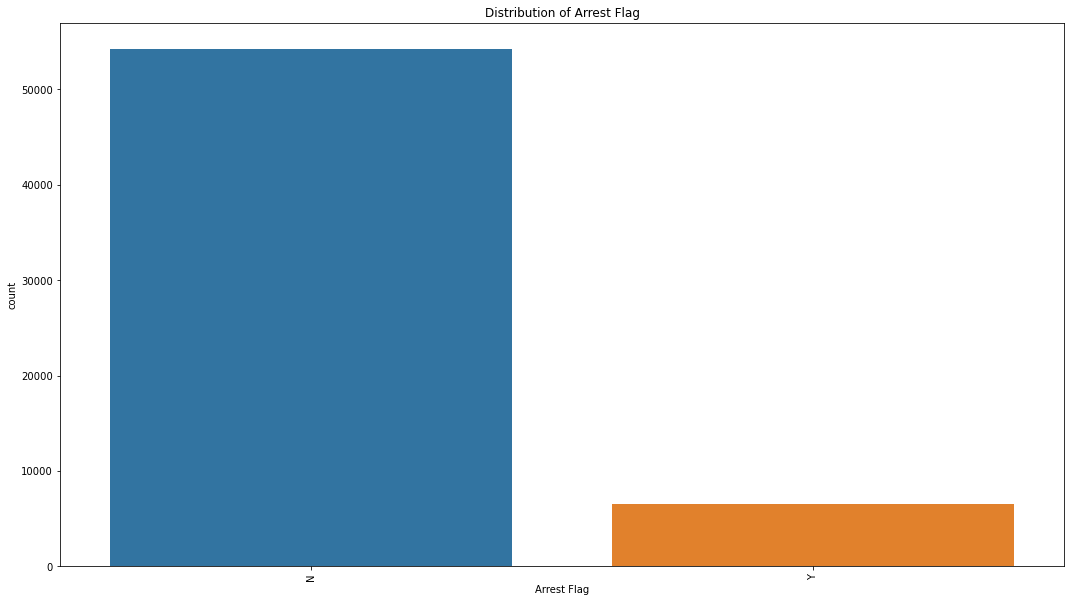

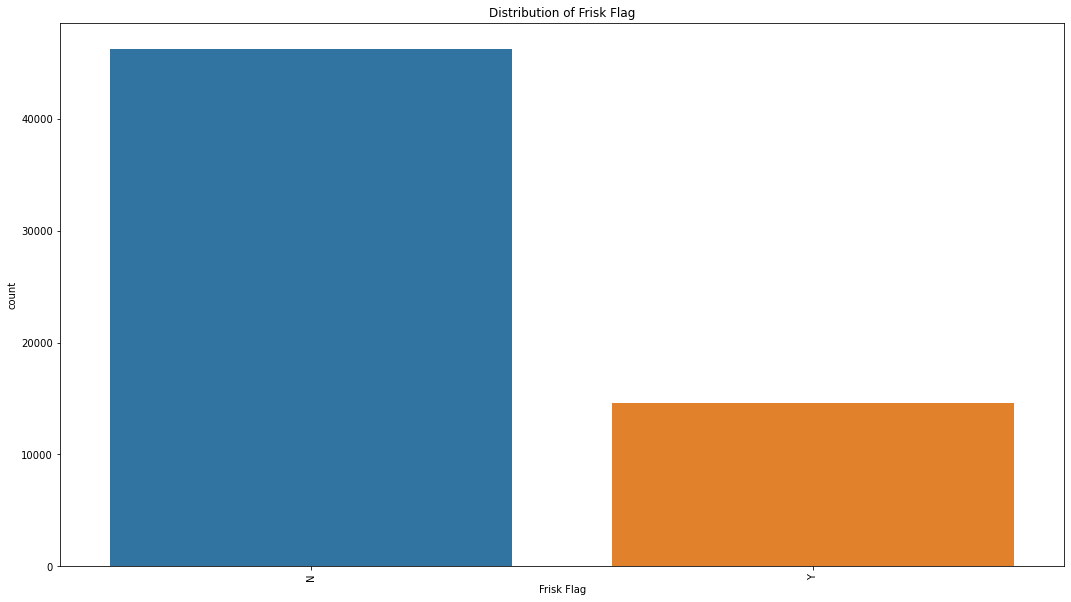

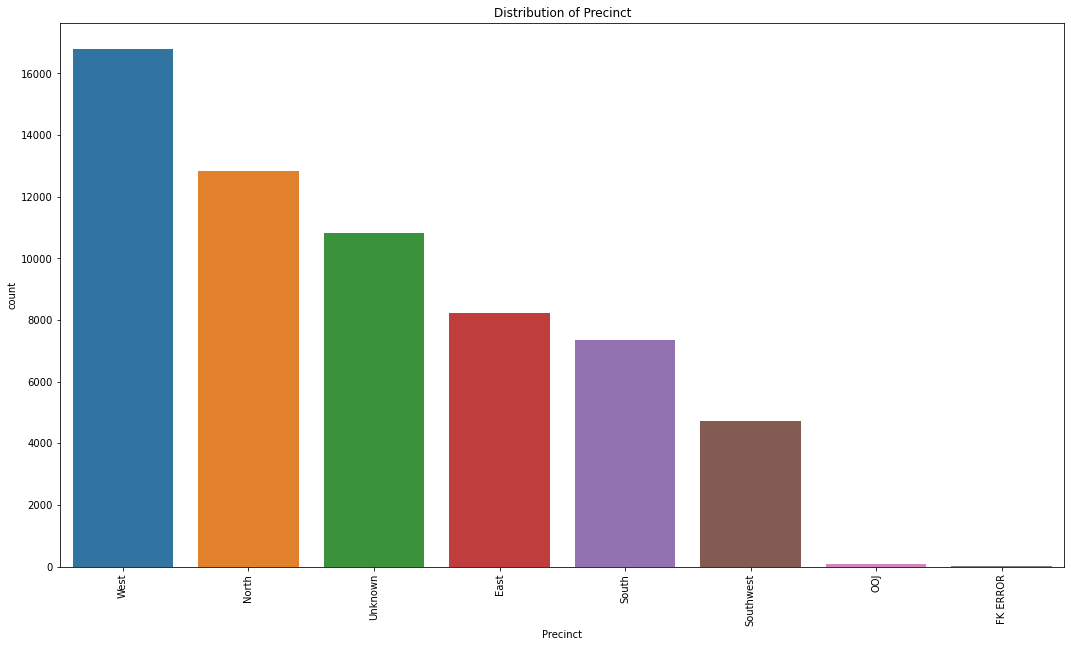

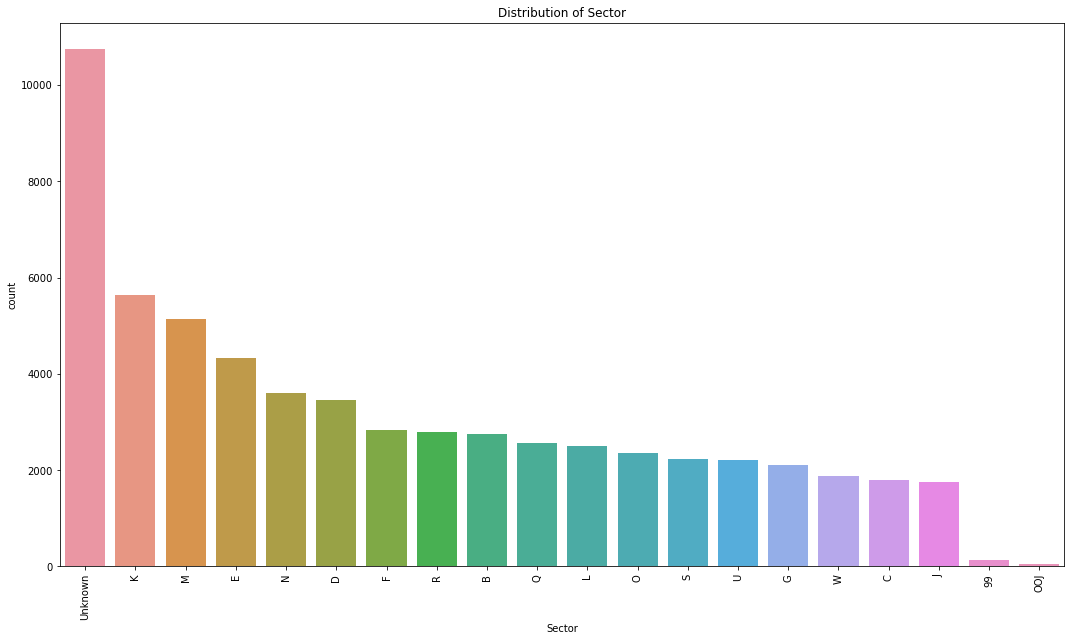

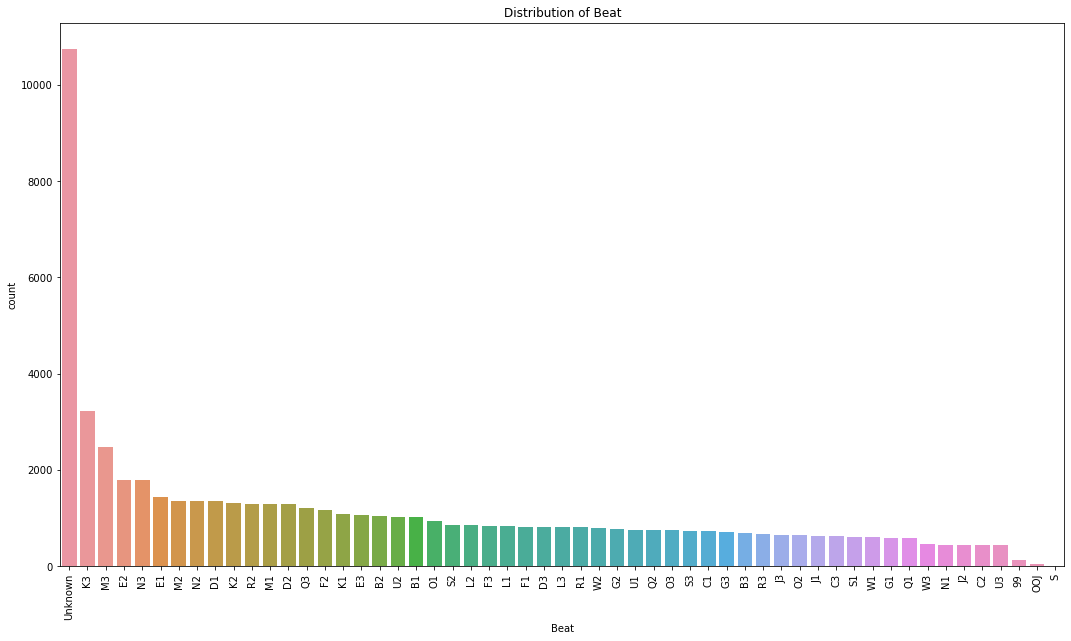

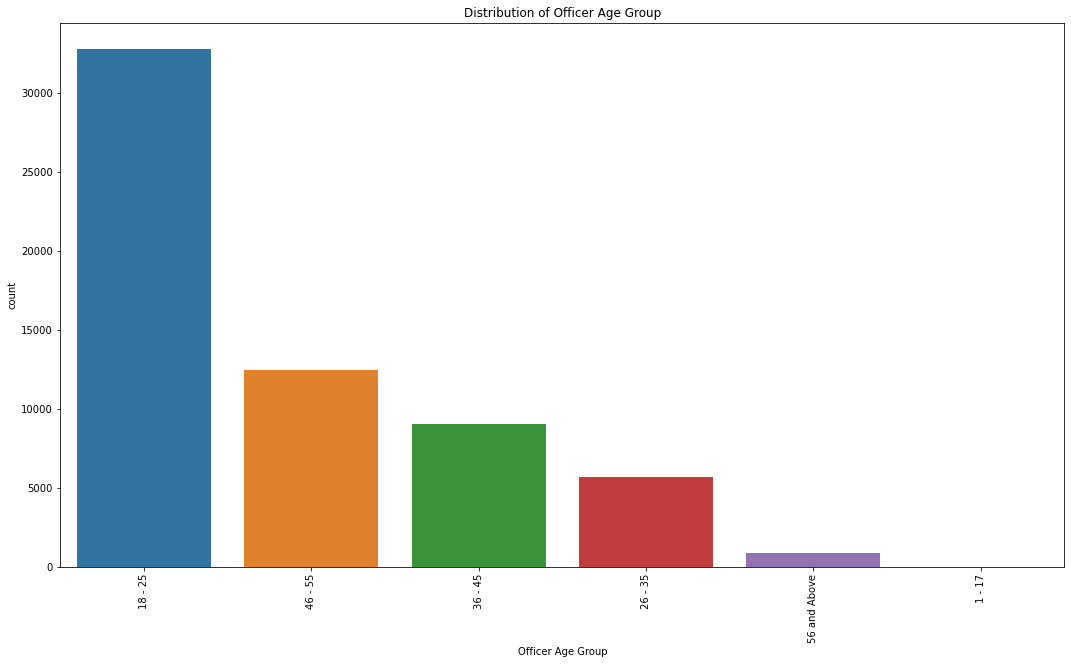

In [51]:
for column in df_preprocessed.columns:
    plt.figure(figsize = (18,10))
    sns.countplot(data=df_preprocessed, x=column, order=df_preprocessed[column].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f'Distribution of {df_preprocessed[column].name}')
    plt.show;